In [85]:
%load_ext autoreload
%autoreload 2
from helper import create_tsp_graph,plot_tsp_graph,bitstring_to_path,cost
from classical import solve_tsp_classical
from alternating_operator import get_expectation,analyse_result
from scipy.optimize import minimize
from qiskit.tools.visualization import plot_histogram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
G = create_tsp_graph(4)

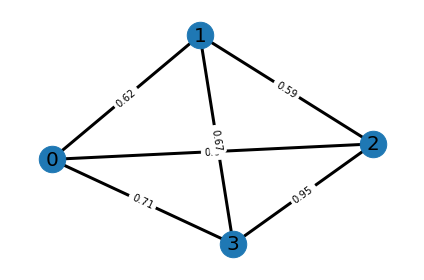

In [108]:
plot_tsp_graph(G)

In [ ]:
reps = 1
expectation = get_expectation(G,reps,shots=512)

res = minimize(expectation, 
                      [1. for _ in range(reps*4)], 
                      method='Nelder-Mead',
                      options = {'disp':True},
                      callback = lambda p: print(p))

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


[1.00625 1.00625 1.00625 1.025  ]


Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


[1.00625 1.00625 1.00625 1.025  ]


Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


[1.00625 1.00625 1.00625 1.025  ]


Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


[1.00625 1.00625 1.00625 1.025  ]


Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


In [ ]:
res

In [ ]:
fig,counts = analyse_result(G,res.x,transform_labels_to_path=True)
fig

In [ ]:
for key, val in counts.items():
    if val>1:
        path = bitstring_to_path(key)
        print(path,':', val , f"   cost = {round(cost(G,path),2)}")

In [28]:
cost(G,[3, 1, 4, 2, 0])

1.6815926576790783

In [20]:
solve_tsp_classical(G)

([3, 1, 4, 2, 0], 1.6815926576790783)

In [66]:
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA
from alternating_operator import create_initial_state_circuit
from qaoa import build_cost
from qiskit.circuit import Parameter
from qiskit import Aer

In [93]:
qaoa = QAOA(optimizer=COBYLA(),reps=2,initial_state =create_initial_state_circuit(3),quantum_instance=Aer.get_backend('aer_simulator'))

In [95]:
cost_ham = build_cost(1.,3,G)

params = [Parameter(i) for i in ['a','b','c','d']]

qc = qaoa.construct_circuit(params,cost_ham)[0]

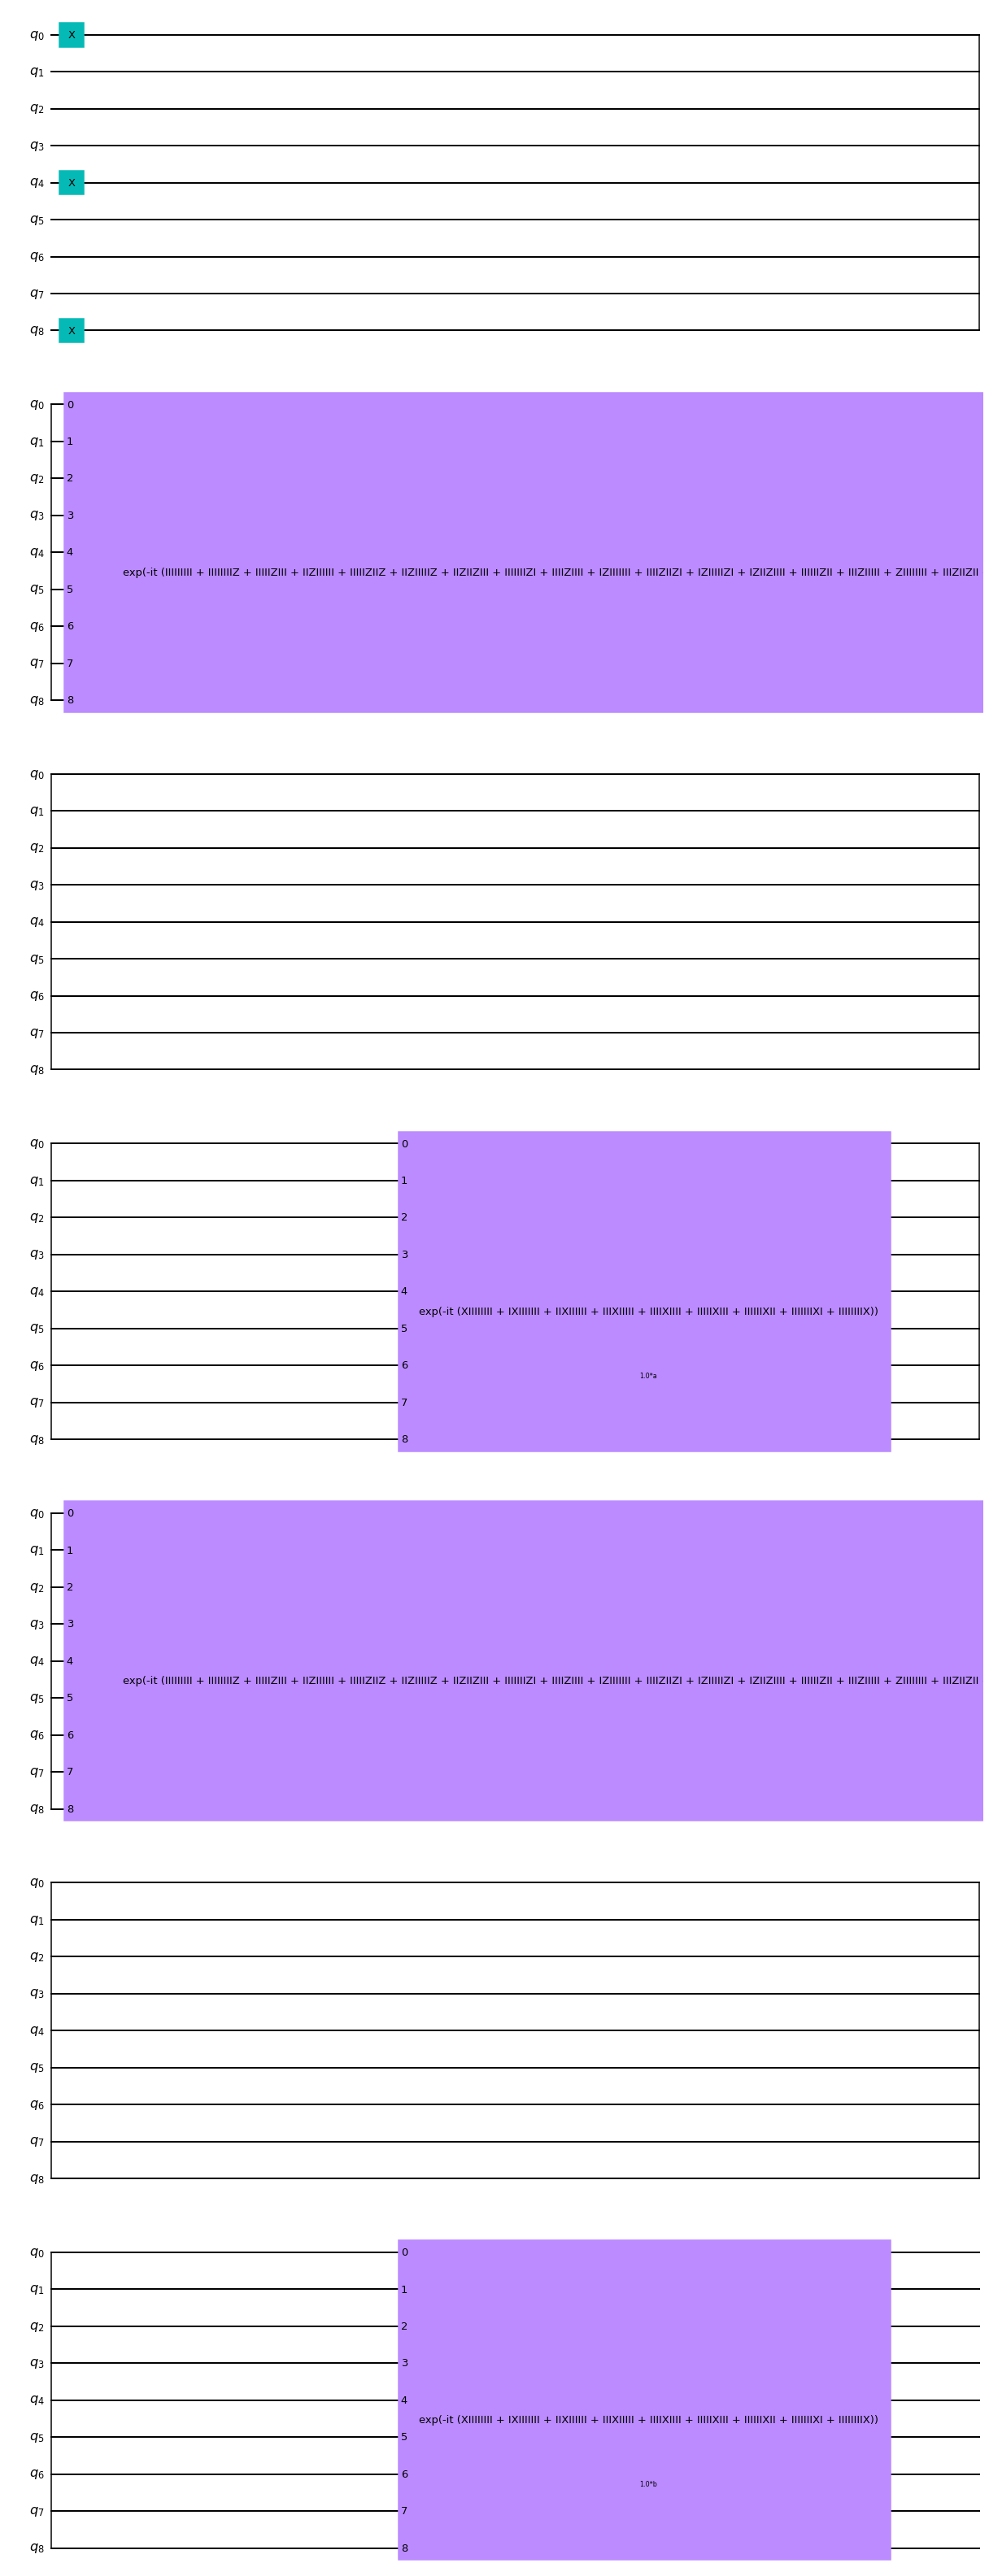

In [96]:
qc.draw('mpl')

In [97]:
res = qaoa.compute_minimum_eigenvalue(cost_ham)

In [98]:
res.eigenstate

{'000010001': 0.03125,
 '100010001': 0.997555606219523,
 '100010011': 0.03125,
 '100110001': 0.04419417382415922,
 '110010001': 0.03125}

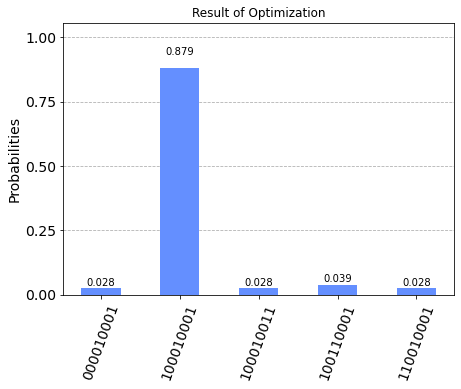

In [99]:
plot_histogram(res.eigenstate, title='Result of Optimization')

In [ ]:
for key, val in counts.items():
    if val>1:
        path = bitstring_to_path(key)
        print(path,':', val , f"   cost = {round(cost(G,path),2)}")